In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import zscore
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from itertools import cycle
from vips import vipp
from calc_metrics import calc_metrics
import random
from collections import Counter
from tqdm import tqdm

In [2]:
#new_raw_counts = pd.read_csv('../data/BAL/Reseq_ALL/counts_reseq.csv', sep='\t', 
#                     index_col='sample_id')
meta = pd.read_csv('../data/BAL/Reseq_ALL/meta_reseq.csv', sep='\t', index_col='sample_id')
new_fpkm = pd.read_csv("../data/BAL/new_counts_fpkm_R.txt",sep='\t')#, index_col='sample_id')

old_fpkm = pd.read_csv('../data/BAL/Run0/granges.fpkms.txt', sep='\t').T
old_meta = pd.read_csv('../data/BAL/meta_r0.csv', sep='\t', index_col=0)

In [3]:
new_fpkm = new_fpkm.T

### Require X % of samples to have Y gene greater than 0

In [4]:
## Enforce minimum percentage of samples that have > min_count
def check_min_percent(df, min_percent, min_count=0):
    new_cols = []
    for gene in df.columns:
        percent_above_zero = float(len([x for x in df[gene].values if x > min_count]))/len(df[gene].values)*100
        if percent_above_zero >= min_percent:
            new_cols.append(gene)
    return df[new_cols]

In [5]:
new_fpkm.shape

(95, 57785)

In [12]:
new_fpkm = new_fpkm.apply(lambda x: np.log2(x + 1))
new_fpkm = check_min_percent(new_fpkm, min_percent=75)

In [59]:
new_fpkm = new_fpkm[[col for col in new_fpkm.columns if col in old_fpkm.columns]]

In [60]:
new_fpkm.shape

(95, 4936)

In [13]:
old_fpkm = old_fpkm.apply(lambda x: np.log2(x + 1))
old_fpkm = check_min_percent(old_fpkm, min_percent=75)

In [14]:
new_fpkm.shape, old_fpkm.shape

((95, 5175), (32, 16746))

## Raw counts to FPKM 

In [15]:
print old_fpkm.shape, old_meta.shape
print new_fpkm.shape, meta.shape

(32, 16746) (32, 2)
(95, 5175) (95, 32)


### In this study we have significantly more negative than positive samples
### The function geteven_xy() returns an even number of neg and pos
   - sampling = 'up' means that a random number of pos samples are added to make up the difference (there are duplicate pos. samples)
   - sampling = 'down' means that a random number of neg. samples are removed (there are no duplicates, but the total number of samples is far fewer than when upsampling). 

In [322]:
new_z = new_fpkm.apply(lambda x: zscore(x))

In [323]:
new_z.head()

,ENSG00000000419,ENSG00000000938,ENSG00000001036,ENSG00000001561,ENSG00000001629,ENSG00000002549,ENSG00000002586,ENSG00000002587,ENSG00000002834,ENSG00000002919,...,ENSG00000277632,ENSG00000277791,ENSG00000278053,ENSG00000278133,ENSG00000278311,ENSG00000278970,ENSG00000279483,ENSG00000279602,ENSG00000279865,ENSG00000283041
R1_BAL17_CD163_S1,0.669837,0.709135,-0.415655,-0.167682,-0.161751,-0.045394,1.055839,0.333772,0.657174,0.256925,...,1.082742,0.518786,0.317610,0.722396,0.618408,0.684693,0.777774,0.785445,-0.917703,-0.923840
R1_BAL25_AM_S2,0.007637,0.146286,0.162909,0.729504,0.789095,0.983479,-0.832816,0.085387,0.218039,1.020973,...,0.168713,0.109019,0.342504,0.639951,0.738580,0.666139,-0.163136,0.788134,0.879809,-0.155531
R1_BAL28_CD163_S3,-0.140794,0.145019,0.414551,0.344053,-0.450359,1.061159,-0.160810,2.030717,0.365263,0.307307,...,1.203624,0.659997,-0.679022,-1.442034,0.475173,1.015945,-2.134756,0.586625,-0.439008,0.182722
R1_BAL38_163_S4,1.432720,0.581286,-0.281883,-0.215439,-0.028928,-0.072849,-0.036668,1.008058,0.401872,-0.590093,...,0.826322,0.495974,0.123143,0.396291,-0.011973,-0.057439,-0.674585,-0.568465,-0.627957,-0.046070
R1_BAL48_AM_S5,-0.348680,-0.024048,1.355590,0.522240,-0.312826,0.694639,0.478532,1.744065,0.478354,0.715553,...,0.050166,0.599654,0.486596,0.307260,0.768787,0.594294,1.339705,1.754669,0.002175,0.927860


In [102]:
def geteven_xy(df, dfm, celltype, sampling='up', z=True):
    dfm = dfm[dfm['CellType']==celltype]
    y = dfm['Pneum'].values
    df = df.ix[dfm.index]
    #    if z: df = df.apply(lambda x: zscore(x))
    genes = df.columns
    pos = [i for i in range(len(y)) if y[i]==True]
    neg = [i for i in range(len(y)) if y[i]==False]
    
    npos = len(pos)
    nneg = len(neg)

    #    print "Num positive: {}".format(len(pos))
    #    print "Num negative: {}".format(len(neg))
    if sampling=='down':
        if nneg >= npos:
            neg = random.sample(neg, npos)
        else:
            pos = random.sample(pos, nneg)
    if sampling=='up':
        if nneg >= npos:
            dup_pos = random.sample(pos+pos, nneg-npos)
            pos = pos + dup_pos ## pos+pos in case not enough in pos
    #            print "duplicated pos:", dup_pos
        else:
            neg = neg + random.sample(neg+neg, npos-nneg)
    
    df = df.ix[(pos+neg),:]
    if z: df = df.apply(lambda x: zscore(x))
    dfm = dfm.ix[(pos+neg),:]
    X = np.array(df)
    y = dfm['Pneum'].values
    #print "Num pos after sampling: {}".format(len(pos))
    #print "Num neg after sampling: {}".format(len(neg))
    #y = y[pos + neg] 
    #X = X[pos + neg] 
    return X,y, genes, df, dfm

## PLSR - Q score

## Still need to compare to jumbled genes

### Build model using new data


## Plot training error, test error

In [119]:
#determine the best number of genes for the training model
def plotQ2(r=np.arange(5,105,5), celltype='AM', sampling='up', z=True):
    Q2s = []
    for n_top_genes in tqdm(r):
        X, y, genes, df, dfm = geteven_xy(new_fpkm, meta, celltype=celltype, sampling=sampling, z=z)
        neg_err, pos_err, Q2, pos_corr, neg_corr, vip_inds = calc_metrics(X, y, 
                                                        n_pcs=5, n_top_genes=n_top_genes)
        Q2s.append(Q2)
    return Q2s

100%|██████████| 40/40 [03:48<00:00,  5.66s/it]


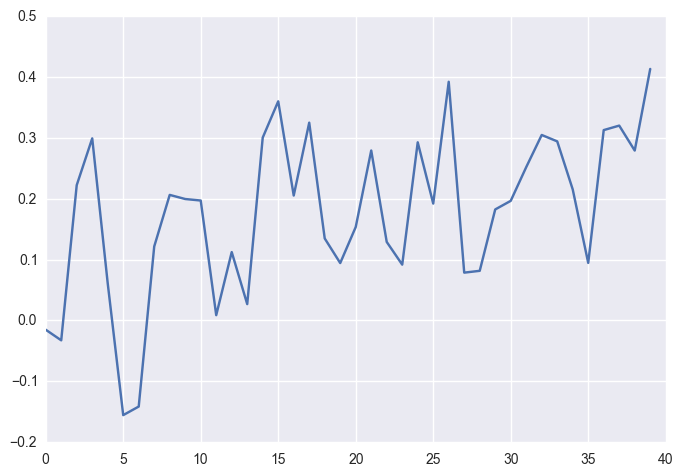

In [127]:
plt.plot(plotQ2(r=np.arange(5,205,5)))

In [124]:
np.arange(5,105,5)[9]

50

In [133]:
np.arange(5,205,5)[18]

95

100%|██████████| 40/40 [03:49<00:00,  5.64s/it]


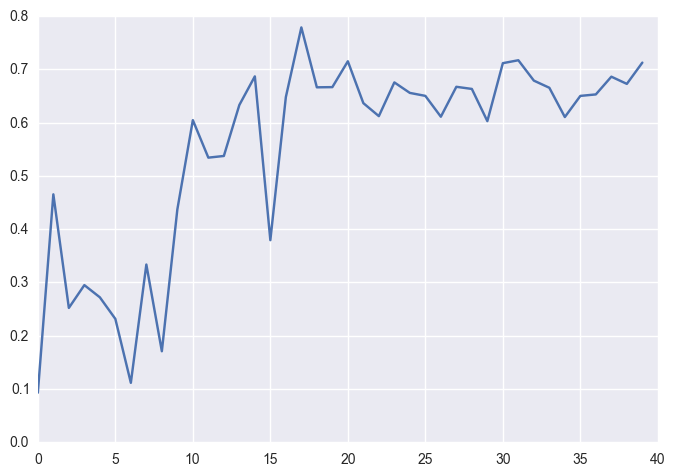

In [128]:
plt.plot(plotQ2(r=np.arange(5,205,5), celltype='CD163'))

In [104]:

def get_accuracy_stats(n, sampling, celltype, 
                   n_top_genes, z=False,
                  flip_test_y=False, flip_train_y=False):
    
    neg_accuracy_train = []
    neg_accuracy_test = []
    pos_accuracy_train = []
    pos_accuracy_test = []
    all_top_genes_train = []
    top_top_genes_train = [] # not a typo - these are the top across random samplings (n) of the top genes from LOO
    old_genes = old_fpkm.columns
    
    ### TRAINING
    #################
    
    ## Get most common genes from each model
    for i in tqdm(range(n), desc="Training"):
        X, y, genes, df, dfm = geteven_xy(new_fpkm, meta, celltype=celltype, sampling=sampling, z=z)
        #print y
        if flip_train_y:
            y = np.array(map(lambda x: True if x==0 else False, y))
        #    print y
        neg_err, pos_err, Q2, pos_corr, neg_corr, vip_inds = calc_metrics(X, y, 
                                                        n_pcs=5, n_top_genes=n_top_genes)
        all_vips = [g for m in vip_inds for g in m]
        c = Counter(all_vips)
        top_inds = [i[0] for i in c.most_common(n_top_genes)]
        top_genes_train = [genes[i] for i in top_inds]
        all_top_genes_train += top_genes_train
        
        neg_accuracy_train.append(neg_corr)
        pos_accuracy_train.append(pos_corr)

    
    ### Get the best of the top genes across all X,y
    c = Counter(all_top_genes_train)
    top_top_genes_train = [i[0] for i in c.most_common(n_top_genes)]
    
    ### Build model based on those genes
    pls = PLSRegression(5, scale=True)
    X = np.array(df[top_top_genes_train])
    y = np.array(dfm['Pneum'])
    pls.fit(X, y)
        
    
    ### TESTING
    ###############
    
    ### Random up-samples of old data for predictions
    for i in tqdm(range(n), desc="Testing"):
        X_test, y_test, genes_test, df_test, dfm_test = geteven_xy(old_fpkm, 
                            old_meta, celltype=celltype, sampling=sampling, z=z)
        #print y_test
        if flip_test_y:
            y_test = np.array(map(lambda x: True if x==0 else False, y_test))
        X_test = np.array(df_test[top_top_genes_train])

        y_pred = pls.predict(X_test)
        
        neg_err = [float(abs(y_pred[i]-y_test[i])) for i in range(len(y_pred)) if y_test[i]==0]
        #print "Negative error: ", neg_err
        neg_acc = float(sum([(e < 0.5) for e in neg_err])) / len(neg_err)
        #print "Negative acc: ", neg_acc
        
        pos_err = [float(abs(y_pred[i]-y_test[i])) for i in range(len(y_pred)) if y_test[i]==1]
        #print "Positive error: ", pos_err
        pos_acc = float(sum([(e < 0.5) for e in pos_err])) / len(pos_err)
        #print "Positive acc: ", pos_acc

        neg_accuracy_test.append(neg_acc)
        pos_accuracy_test.append(pos_acc)
        
    #print "positive error mean= {}".format(np.mean(pos_err))
    #print "negative error mean= {}".format(np.mean(neg_err))
    return neg_accuracy_train, neg_accuracy_test, pos_accuracy_train, pos_accuracy_test

### Get genes from mean of train -> test

# AM cells

## AM - top 20 genes - 
### downsampling

In [99]:
testAM_down = get_accuracy_stats(n=20, celltype='AM', 
                        n_top_genes=50, sampling='down', 
                        z=True, flip_test_y=False, flip_train_y=False)


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Num positive: 19
Num negative: 30
negs [27, 6, 25, 8, 43, 9, 7, 10, 5, 3, 45, 39, 19, 38, 42, 20, 16, 28, 0]
poss [1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]


Training:   5%|▌         | 1/20 [00:03<01:06,  3.50s/it]

Num positive: 19
Num negative: 30
negs [27, 7, 0, 25, 18, 6, 48, 19, 42, 13, 10, 43, 14, 39, 38, 12, 41, 21, 5]
poss 

Training:  10%|█         | 2/20 [00:06<01:02,  3.46s/it]

[1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]
Num positive: 19
Num negative: 30
negs [27, 41, 8, 18, 48, 10, 42, 20, 7, 17, 5, 38, 21, 2, 43, 6, 28, 34, 12]
poss 

Training:  15%|█▌        | 3/20 [00:10<00:58,  3.42s/it]

[1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]
Num positive: 19
Num negative: 30
negs [45, 9, 2, 22, 12, 20, 34, 10, 14, 13, 42, 3, 48, 39, 0, 41, 7, 16, 18]
poss [1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]

Training:  20%|██        | 4/20 [00:13<00:55,  3.48s/it]


Num positive: 19
Num negative: 30
negs [12, 38, 0, 10, 48, 3, 39, 13, 18, 17, 41, 6, 9, 14, 45, 2, 27, 42, 16]

Training:  25%|██▌       | 5/20 [00:17<00:55,  3.68s/it]


poss [1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]
Num positive: 19
Num negative: 30
negs [19, 6, 3, 5, 28, 38, 9, 7, 10, 45, 12, 21, 25, 48, 8, 27, 0, 18, 43]


Training:  30%|███       | 6/20 [00:21<00:52,  3.73s/it]

poss [1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]
Num positive: 19
Num negative: 30
negs [28, 39, 42, 16, 5, 20, 2, 48, 41, 3, 13, 7, 21, 18, 14, 45, 38, 27, 22]
poss

Training:  35%|███▌      | 7/20 [00:25<00:47,  3.68s/it]

 [1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]
Num positive: 19
Num negative: 30
negs [8, 21, 20, 18, 10, 17, 3, 34, 22, 5, 25, 48, 16, 41, 13, 43, 12, 9, 27]
poss [1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]


Training:  40%|████      | 8/20 [00:29<00:46,  3.89s/it]

Num positive: 19
Num negative: 30
negs [2, 17, 14, 21, 28, 27, 43, 19, 5, 7, 41, 45, 25, 34, 12, 16, 38, 10, 6]
poss [1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]

Training:  45%|████▌     | 9/20 [00:33<00:42,  3.87s/it]


Num positive: 19
Num negative: 30
negs [6, 0, 22, 25, 34, 42, 8, 27, 18, 20, 7, 3, 12, 43, 38, 28, 13, 45, 10]
poss [1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]


Training:  50%|█████     | 10/20 [00:36<00:37,  3.73s/it]

Num positive: 19
Num negative: 30
negs [27, 14, 19, 28, 12, 41, 7, 39, 16, 13, 42, 38, 8, 10, 22, 45, 48, 9, 20]
poss [1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]


Training:  55%|█████▌    | 11/20 [00:40<00:33,  3.72s/it]

Num positive: 19
Num negative: 30
negs [2, 13, 3, 17, 28, 7, 9, 12, 34, 14, 27, 22, 25, 41, 38, 45, 19, 21, 43]
poss [1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]


Training:  60%|██████    | 12/20 [00:44<00:29,  3.67s/it]

Num positive: 19
Num negative: 30
negs [8, 20, 3, 48, 7, 17, 5, 39, 9, 45, 41, 38, 13, 19, 16, 14, 42, 12, 28]
poss [1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]


Training:  65%|██████▌   | 13/20 [00:47<00:25,  3.61s/it]

Num positive: 19
Num negative: 30
negs [21, 6, 22, 7, 18, 12, 0, 20, 10, 16, 19, 8, 17, 48, 38, 27, 43, 39, 42]
poss [1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]


Training:  70%|███████   | 14/20 [00:51<00:21,  3.54s/it]

Num positive: 19
Num negative: 30
negs [12, 6, 8, 9, 5, 42, 39, 17, 21, 16, 25, 27, 34, 14, 0, 18, 2, 10, 19]
poss

Training:  75%|███████▌  | 15/20 [00:54<00:17,  3.47s/it]

 [1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]
Num positive: 19
Num negative: 30
negs [39, 10, 3, 48, 18, 2, 42, 5, 7, 9, 6, 12, 41, 27, 21, 34, 16, 14, 20]
poss 

Training:  80%|████████  | 16/20 [00:57<00:13,  3.42s/it]

[1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]
Num positive: 19
Num negative: 30
negs [48, 7, 3, 38, 9, 22, 43, 34, 8, 20, 14, 10, 21, 16, 27, 5, 12, 0, 6]

Training:  85%|████████▌ | 17/20 [01:01<00:10,  3.46s/it]


poss [1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]
Num positive: 19
Num negative: 30
negs [13, 5, 39, 8, 2, 45, 38, 12, 3, 14, 27, 20, 43, 6, 19, 21, 48, 18, 16]


Training:  90%|█████████ | 18/20 [01:05<00:07,  3.63s/it]

poss [1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]
Num positive: 19
Num negative: 30
negs [48, 38, 5, 17, 28, 45, 21, 8, 14, 19, 7, 27, 3, 25, 43, 18, 12, 0, 16]
poss [1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]


Training:  95%|█████████▌| 19/20 [01:08<00:03,  3.56s/it]

Num positive: 19
Num negative: 30
negs [25, 3, 6, 13, 10, 12, 8, 48, 42, 20, 38, 5, 0, 17, 41, 39, 18, 9, 7]
poss [1, 4, 11, 15, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 40, 44, 46, 47]


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Num positive: 6
Num negative: 14
negs [18, 7, 3, 4, 2, 0]
poss [5, 11, 12, 13, 14, 17]


Testing:   5%|▌         | 1/20 [00:02<00:55,  2.90s/it]

Negative error:  [0.4167491681997306, 0.47693099129527255, 0.3071925490985193, 0.2495797311167512, 0.48030703085307314, 0.6123626602604819]
Negative acc:  0.833333333333
Positive error:  [0.04072269529506212, 0.6252858590138783, 0.6605991315553595, 0.5325541447511324, 0.3969029810204041, 0.28705731918799615]
Positive acc:  0.5
Num positive: 6
Num negative: 14
negs [0, 1, 2, 6, 10, 15]
poss [5, 11, 12, 13, 14, 17]


Testing:  10%|█         | 2/20 [00:05<00:51,  2.87s/it]

Negative error:  [0.43529331479308664, 0.5748581873823038, 0.2976885124208652, 0.6256410759622204, 0.3150002212681219, 1.137702058873796]
Negative acc:  0.5
Positive error:  [0.19980770729521757, 0.7991740255138325, 0.7639837048533495, 0.6391365387085106, 0.5720135190283548, 0.41206787530113076]
Positive acc:  0.333333333333
Num positive: 6
Num negative: 14
negs [7, 15, 10, 0, 4, 2]
poss [5, 11, 12, 13, 14, 17]


Testing:  15%|█▌        | 3/20 [00:08<00:50,  2.99s/it]

Negative error:  [0.4329313969433265, 1.187519473437869, 0.42566373410160513, 0.49771305992959447, 0.2288400215692778, 0.3970781490488367]
Negative acc:  0.833333333333
Positive error:  [0.17276378903068035, 0.7327942986849801, 0.7500074203299907, 0.6081303932669029, 0.5144626991635122, 0.39158723455444466]
Positive acc:  0.333333333333
Num positive: 6
Num negative: 14


Testing:  20%|██        | 4/20 [00:12<00:49,  3.08s/it]

negs [15, 8, 0, 16, 19, 2]
poss [5, 11, 12, 13, 14, 17]
Negative error:  [1.2696396441457718, 0.044802652072369, 0.6148635176953255, 0.0942324677417603, 0.48748795023100844, 0.43624007792100655]
Negative acc:  0.666666666667
Positive error:  [0.08857811647384872, 0.686300600754881, 0.7210556600559423, 0.6086182925675715, 0.5125253022391486, 0.33018833771585254]
Positive acc:  0.333333333333
Num positive: 6
Num negative: 14
negs [0, 19, 10, 4, 9, 18]
poss

Testing:  25%|██▌       | 5/20 [00:15<00:45,  3.06s/it]

 [5, 11, 12, 13, 14, 17]
Negative error:  [0.5456006405103249, 0.5475717968236387, 0.4792169647809161, 0.24420381652874695, 0.3309530634412751, 0.40964057109382]
Negative acc:  0.666666666667
Positive error:  [0.02707767964471408, 0.6939447926082888, 0.6707145572672063, 0.49166064397172315, 0.3844837233287888, 0.28930545635800287]
Positive acc:  0.666666666667
Num positive: 6
Num negative: 14
negs [4, 3, 15, 16, 9, 7]
poss [5, 11, 12, 13, 14, 17]


Testing:  30%|███       | 6/20 [00:18<00:42,  3.04s/it]

Negative error:  [0.31224832479826636, 0.36785350434121583, 1.1844299280668118, 0.17922018419824326, 0.33595284980870344, 0.49231741849713523]
Negative acc:  0.833333333333
Positive error:  [0.1439333478586351, 0.647819887658314, 0.6725196079082015, 0.5979792738754912, 0.4668904861074681, 0.3428796063022679]
Positive acc:  0.5
Num positive: 6
Num negative: 14
negs [18, 4, 8, 2, 16, 1]
poss [5, 11, 12, 13, 14, 17]


Testing:  35%|███▌      | 7/20 [00:21<00:41,  3.20s/it]

Negative error:  [0.45442945978654536, 0.3353473196249788, 0.16087792589141786, 0.5082493811106615, 0.19508101033512554, 0.7571170019169822]
Negative acc:  0.666666666667
Positive error:  [0.02307455112436041, 0.6351307965207987, 0.6093904402326902, 0.4987287878637886, 0.39455437797237547, 0.2502231449516985]
Positive acc:  0.666666666667
Num positive: 6
Num negative: 14
negs [1, 19, 9, 18, 2, 16]
poss [5, 11, 12, 13, 14, 17]


Testing:  40%|████      | 8/20 [00:25<00:39,  3.27s/it]

Negative error:  [0.6674420888317081, 0.5450854376563015, 0.3162582374913564, 0.42799423346242965, 0.4613885782098377, 0.1249089625799849]
Negative acc:  0.666666666667
Positive error:  [0.006354825285200039, 0.6623863120192652, 0.6626487392899385, 0.5184138099105251, 0.4063047088308579, 0.28696914289583164]
Positive acc:  0.5
Num positive: 6
Num negative: 14
negs

Testing:  45%|████▌     | 9/20 [00:28<00:36,  3.29s/it]

 [7, 6, 9, 0, 4, 1]
poss [5, 11, 12, 13, 14, 17]
Negative error:  [0.43862444179398424, 0.7434048629026738, 0.2811295061233832, 0.5060442280482111, 0.1832818251886803, 0.6465713688989289]
Negative acc:  0.5
Positive error:  [0.06048965885020008, 0.7438933436995291, 0.6808790378889447, 0.5291854066853492, 0.4441560751702166, 0.34045271066162197]
Positive acc:  0.5
Num positive: 6
Num negative: 14
negs [2, 4, 19, 18, 9, 10]
poss [5, 11, 12, 13, 14, 17]


Testing:  50%|█████     | 10/20 [00:31<00:31,  3.16s/it]

Negative error:  [0.4742233913513683, 0.2636368952928403, 0.5629254354253541, 0.4258555921985267, 0.3369914919211913, 0.5010887215348588]
Negative acc:  0.666666666667
Positive error:  [0.0357695873563888, 0.6775039702799, 0.6743219598918396, 0.49249760963563305, 0.3802357982913348, 0.30439260226904497]
Positive acc:  0.666666666667
Num positive: 6
Num negative: 14
negs [19, 3, 4, 15, 0, 9]
poss [5, 11, 12, 13, 14, 17]


Testing:  55%|█████▌    | 11/20 [00:34<00:29,  3.25s/it]

Negative error:  [0.44570900609898445, 0.2868262644434338, 0.24073051726976535, 1.1751970075721894, 0.5446034337492183, 0.30177808258163263]
Negative acc:  0.666666666667
Positive error:  [0.1383073287921528, 0.7045974540359929, 0.6906011827463523, 0.6065452451793184, 0.49927174864039126, 0.3555213523210179]
Positive acc:  0.5
Num positive: 6
Num negative: 14
negs [0, 7, 4, 18, 2, 19]
poss [5, 11, 12, 13, 14, 17]


Testing:  60%|██████    | 12/20 [00:38<00:26,  3.28s/it]

Negative error:  [0.5581169218521941, 0.477736001671844, 0.2379275281076942, 0.3877113145599215, 0.46346269511655513, 0.5352230351529532]
Negative acc:  0.666666666667
Positive error:  [0.001564782010027299, 0.6833891856904426, 0.7210956488782455, 0.5180721693334998, 0.4247705133367481, 0.31128519721220094]
Positive acc:  0.5
Num positive: 6
Num negative: 14
negs 

Testing:  65%|██████▌   | 13/20 [00:41<00:22,  3.16s/it]

[8, 3, 10, 0, 15, 4]
poss [5, 11, 12, 13, 14, 17]
Negative error:  [0.14848547288054692, 0.30385818147192223, 0.4679182684555526, 0.5708803501425244, 1.1719680744714718, 0.2657465393417452]
Negative acc:  0.666666666667
Positive error:  [0.17040042310786152, 0.6946564197692886, 0.6673068641772061, 0.5902061531988281, 0.47720201870172263, 0.32908500780885686]
Positive acc:  0.5
Num positive: 6
Num negative: 14
negs [8, 10, 9, 16, 4, 3]
poss [5, 11, 12, 13, 14, 17]


Testing:  70%|███████   | 14/20 [00:43<00:18,  3.02s/it]

Negative error:  [0.2472221983055347, 0.5681326205848677, 0.39028673601591657, 0.23287142553846057, 0.33873382727615353, 0.4136904128838388]
Negative acc:  0.833333333333
Positive error:  [0.036092077674200196, 0.5847636092219151, 0.5575453184774086, 0.4713206136809661, 0.3206591110915272, 0.22055649045875614]
Positive acc:  0.666666666667
Num positive: 6
Num negative: 14
negs [1, 19, 18, 3, 7, 9]
poss [5, 11, 12, 13, 14, 17]


Testing:  75%|███████▌  | 15/20 [00:46<00:15,  3.03s/it]

Negative error:  [0.6323434542942564, 0.5089504626081528, 0.39677312057336717, 0.3224302878368447, 0.45893164345628457, 0.30557422792576816]
Negative acc:  0.666666666667
Positive error:  [0.023854652202966786, 0.6869899218149442, 0.6681343358788181, 0.5424362997440791, 0.42284620622922386, 0.28074178082464085]
Positive acc:  0.5
Num positive: 6
Num negative: 14
negs [2, 7, 4, 19, 16, 0]
poss [5, 11, 12, 13, 14, 17]


Testing:  80%|████████  | 16/20 [00:49<00:11,  2.94s/it]

Negative error:  [0.48277488212186564, 0.4926037142386854, 0.2686965483458368, 0.5457206035826119, 0.11458361345875984, 0.6064289965929583]
Negative acc:  0.666666666667
Positive error:  [0.005113999443389972, 0.6414105048967631, 0.6743130600837127, 0.5044494331191808, 0.40410652568697225, 0.29164283399748114]
Positive acc:  0.5
Num positive: 6
Num negative: 14
negs [15, 6, 2, 1, 7, 19]
poss [5, 11, 12, 13, 14, 17]


Testing:  85%|████████▌ | 17/20 [00:52<00:08,  2.95s/it]

Negative error:  [1.163532076589775, 0.6506527440832901, 0.3055963310381048, 0.5963959620176617, 0.34631138571095343, 0.3805879296669892]
Negative acc:  0.5
Positive error:  [0.16895315232920738, 0.8160788910186252, 0.7923232703207115, 0.6513926506144998, 0.5910094784461422, 0.4233189863775909]
Positive acc:  0.333333333333
Num positive: 6
Num negative: 14
negs [15, 1, 6, 18, 4, 10]
poss [5, 11, 12, 13, 14, 17]


Testing:  90%|█████████ | 18/20 [00:55<00:05,  2.89s/it]

Negative error:  [1.1255092440983159, 0.6184823668159612, 0.6707729768577742, 0.29767562722151, 0.19485419808962223, 0.3820901890828551]
Negative acc:  0.5
Positive error:  [0.2229136686760118, 0.7727164699157814, 0.7327898976873156, 0.6284137007321825, 0.5363478601777002, 0.39620300497704886]
Positive acc:  0.333333333333
Num positive: 6
Num negative: 14
negs [3, 0, 8, 2, 10, 7]
poss [5, 11, 12, 13, 14, 17]

Testing:  95%|█████████▌| 19/20 [00:58<00:02,  2.87s/it]


Negative error:  [0.31100839573478384, 0.6207252429319643, 0.11890976826716199, 0.46601715789569786, 0.4488125733315916, 0.4785780177385128]
Negative acc:  0.833333333333
Positive error:  [0.02288134532592412, 0.6337221182854059, 0.6392966657401102, 0.5077576173929317, 0.3834558407329258, 0.256937568422416]
Positive acc:  0.5
Num positive: 6
Num negative: 14
negs [19, 4, 8, 18, 7, 10]
poss [5, 11, 12, 13, 14, 17]


Testing: 100%|██████████| 20/20 [01:01<00:00,  3.14s/it]

Negative error:  [0.5620434714306878, 0.31165794037576555, 0.13763177179312203, 0.4374852837645849, 0.5324387934264104, 0.5210786939645246]
Negative acc:  0.5
Positive error:  [0.051647065004179926, 0.6509355006088154, 0.653197293289125, 0.5134719674428659, 0.3780286506832382, 0.255055477726871]
Positive acc:  0.5


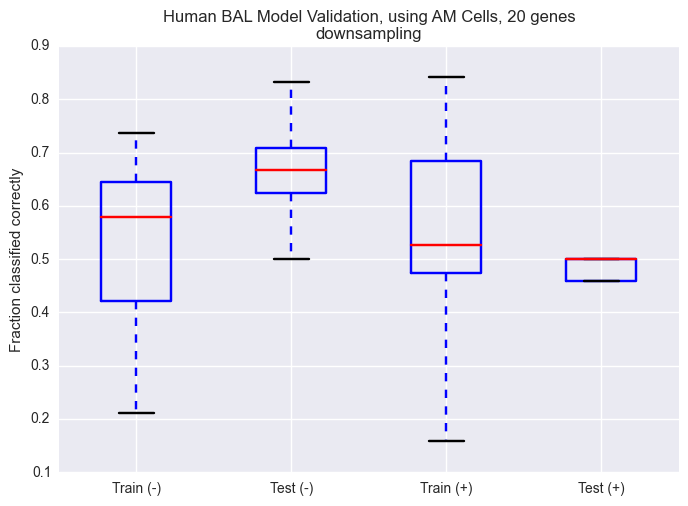

In [100]:
# AM
plt.boxplot(list(testAM_down), labels=('Train (-)', 'Test (-)', 'Train (+)','Test (+)'))
plt.ylabel("Fraction classified correctly")
plt.title("Human BAL Model Validation, using AM Cells, 20 genes\ndownsampling")

## up-sampling

In [136]:
testAM_up_100genes = get_accuracy_stats(n=50, celltype='AM', 
                        n_top_genes=100, sampling='up', 
                        z=True, flip_test_y=False, flip_train_y=False)


Testing: 100%|██████████| 50/50 [02:23<00:00,  2.75s/it]


## AM, upsampling, 100 genes

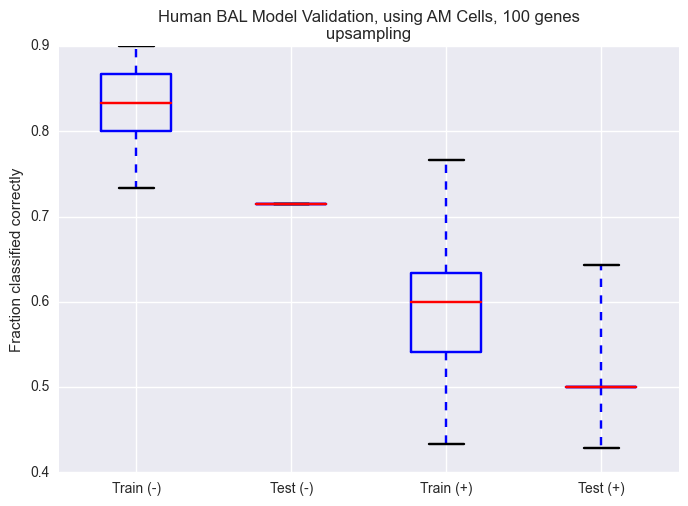

In [158]:
# AM
plt.boxplot(list(testAM_up_100genes), labels=('Train (-)', 'Test (-)', 'Train (+)','Test (+)'))
plt.ylabel("Fraction classified correctly")
plt.title("Human BAL Model Validation, using AM Cells, 100 genes\nupsampling")

In [161]:
testAM_up_100genes

([0.6666666666666666,
  0.8666666666666667,
  0.8,
  0.9,
  0.7666666666666667,
  0.8333333333333334,
  0.8666666666666667,
  0.8666666666666667,
  0.8666666666666667,
  0.8666666666666667,
  0.9,
  0.8666666666666667,
  0.8666666666666667,
  0.7666666666666667,
  0.8,
  0.8333333333333334,
  0.8,
  0.7666666666666667,
  0.8,
  0.8333333333333334,
  0.7666666666666667,
  0.8333333333333334,
  0.8,
  0.8333333333333334,
  0.8333333333333334,
  0.8666666666666667,
  0.8,
  0.8,
  0.8,
  0.8333333333333334,
  0.8666666666666667,
  0.8666666666666667,
  0.9,
  0.8333333333333334,
  0.8666666666666667,
  0.7666666666666667,
  0.8,
  0.7666666666666667,
  0.8666666666666667,
  0.7333333333333333,
  0.8,
  0.8666666666666667,
  0.7666666666666667,
  0.8666666666666667,
  0.8333333333333334,
  0.6666666666666666,
  0.7,
  0.8333333333333334,
  0.8333333333333334,
  0.8],
 [0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143,
  0.7142857142857143,
  0.7142857142

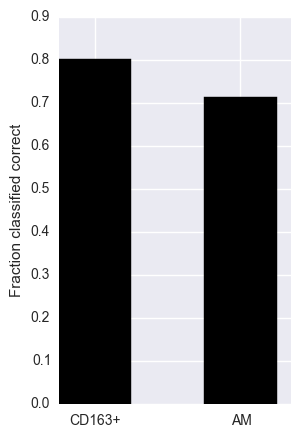

In [188]:
index = np.arange(2)
width = 0.5
plt.figure(num=None, figsize=(3, 5), dpi=80, facecolor='w', edgecolor='k')
plt.bar(index, [np.mean(test163_up[1]), np.mean(testAM_up_100genes[1])], width=width, color='k')
plt.xticks(index + width / 2, ('CD163+', 'AM'))
plt.ylabel("Fraction classified correct")

In [160]:
test163_up[1]

[0.7142857142857143,
 0.8571428571428571,
 0.7142857142857143,
 0.7142857142857143,
 0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.7142857142857143,
 0.7142857142857143,
 0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.7142857142857143,
 0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.5714285714285714,
 0.8571428571428571,
 0.7142857142857143,
 0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.7142857142857143,
 0.7142857142857143,
 0.8571428571428571,
 0.7142857142857143,
 0.8571428571428571,
 0.7142857142857143,
 0.7142857142857143,
 0.8571428571428571,
 0.8571428571428571,
 0.7142857142857143,
 0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.7142857142857143,
 0.8571428571428571,
 0.7142857142857143,
 0.8571428571428571,
 0.8571428571428571,
 0.7142857142

## CD163, upsampling,  100 genes

In [134]:
test163_up = get_accuracy_stats(n=50, celltype='CD163', 
                        n_top_genes=100, sampling='up', 
                        z=True, flip_test_y=False, flip_train_y=False)


Testing: 100%|██████████| 50/50 [02:28<00:00,  2.85s/it]


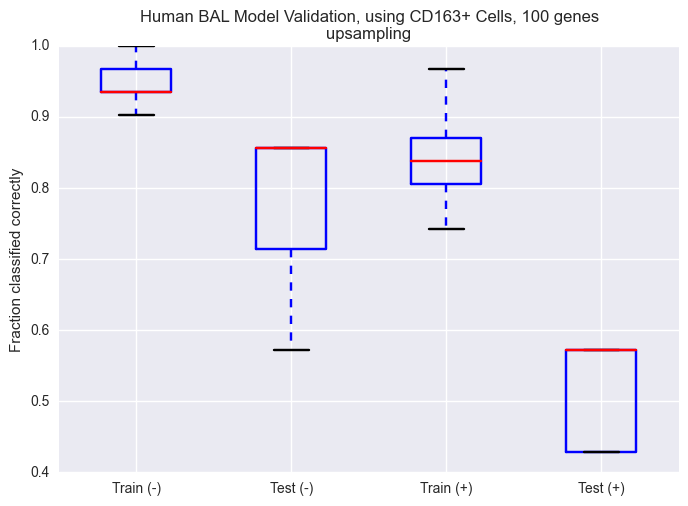

In [135]:
# AM
plt.boxplot(list(test163_up), labels=('Train (-)', 'Test (-)', 'Train (+)','Test (+)'))
plt.ylabel("Fraction classified correctly")
plt.title("Human BAL Model Validation, using CD163+ Cells, 100 genes\nupsampling")

## AM, upsampling, 20 genes

In [156]:
len(old_meta.index.unique())

32

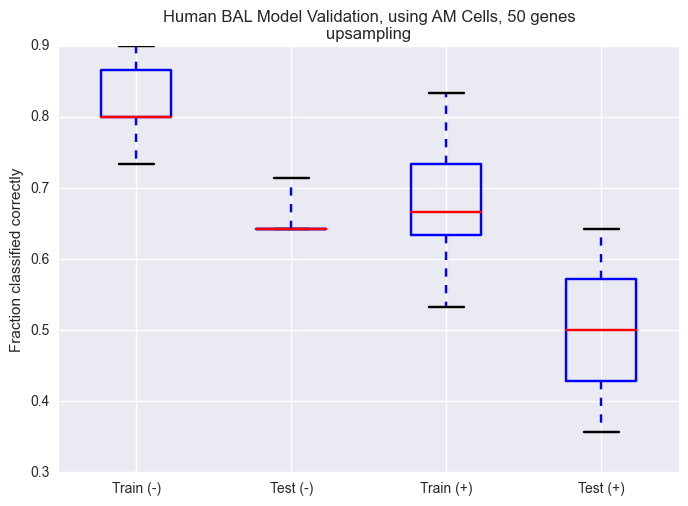

In [132]:
# AM
plt.boxplot(list(testAM_up), labels=('Train (-)', 'Test (-)', 'Train (+)','Test (+)'))
plt.ylabel("Fraction classified correctly")
plt.title("Human BAL Model Validation, using AM Cells, 50 genes\nupsampling")

## CD163, upsampling,  50 genes

In [130]:
test163_up = get_accuracy_stats(n=50, celltype='CD163', 
                        n_top_genes=50, sampling='up', 
                        z=True, flip_test_y=False, flip_train_y=False)


Testing: 100%|██████████| 50/50 [02:23<00:00,  2.83s/it]


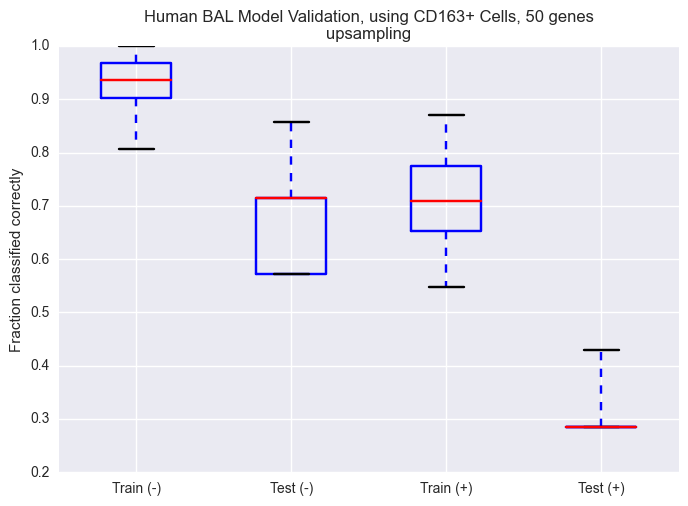

In [131]:
# AM
plt.boxplot(list(test163_up), labels=('Train (-)', 'Test (-)', 'Train (+)','Test (+)'))
plt.ylabel("Fraction classified correctly")
plt.title("Human BAL Model Validation, using CD163+ Cells, 50 genes\nupsampling")

In [20]:
def calc_metrics(X, y, n_pcs, n_top_genes):
    
    n_samples = len(X)
    pred = []
    vip_inds_all = []
    #print X.shape, y.shape
    
    ### Leave-One-Out Cross-validation
    
    for sample in range(n_samples):
        samples = range(n_samples)
        samples.remove(sample)
        X_t = X[(samples)]
        y_t = y[(samples)]
        #print X_t.shape    
        
        ### Get VIPs for model built without the LOO sample
        plsv = PLSRegression(5, scale=False)
        plsv.fit(X_t, y_t)
        vips = vipp(X_t, y_t, plsv.x_scores_, plsv.x_weights_)
        vips = [float(v) for v in vips]
        vip_inds = np.argsort(vips)[::-1][:n_top_genes]
        vip_inds_all.append(vip_inds)
        
        ### Xn takes the original X to get the loo sample
        Xn = X.T[vip_inds].T
        loo_sample = Xn[sample]
        loo_sample = np.array(loo_sample).reshape((1, -1))
        
        ### Filter the samples 
        X_tn = X_t.T[vip_inds].T
        #print X_tn.shape
        pls = PLSRegression(n_pcs, scale=False)
        pls.fit(X_tn, y_t)

        pred.append(float(pls.predict(loo_sample)))

    # Calculate metrics
    ### Q squared
    num = sum([float((pred[i] - y[i]))**2 for i in range(len(pred))])
    den = sum([(y[i] - np.mean(y))**2 for i in range(len(pred))])
    Q2 = float(1 - num/den)

    ### Prediction error
    errs = [abs(float((pred[i] - y[i]))) for i in range(len(pred))]
 
    ### Percent correct for neg and pos Pneumonia
    neg_err = [errs[i] for i in range(len(errs)) if y[i]==0]  
    neg_corr = [e < 0.5 for e in neg_err]   
    neg_corr = float(sum(neg_corr)) / len(neg_err)

    
    pos_err = [errs[i] for i in range(len(errs)) if y[i]==1]
    pos_corr = [e < 0.5 for e in pos_err]
    pos_corr = float(sum(pos_corr)) / len(pos_err)
    

    #print "num: {0: .3f}, den: {1: .3f}, 
    #print "Q^2: {0: .3f}".format(Q2)
    
    return neg_err, pos_err, Q2, neg_corr, pos_corr, vip_inds_all
    #return [float(abs(pred[p] - y[p])) for p in range(len(pred))]

In [21]:
def vipp(x, y, t, w):

    """
    From original MATLAB code
    See https://code.google.com/p/carspls/

    #+++ vip=vipp(x,y,t,w);
    #+++ t: scores, which can be obtained by pls_nipals.m
    #+++ w: weight, which can be obtained by pls_nipals.m
    #+++ to calculate the vip for each variable to the response;
    #+++ vip=sqrt(p*q/s);
    """
    #initializing
    [p, h] = w.shape
    co = np.matrix(np.zeros([1, h]))

    # Calculate s
    for ii in range(h):
        corr = np.corrcoef(y, t[:, ii], rowvar=0)
        co[0, ii] = corr[0, 1]**2
    s = np.sum(co)

    # Calculate q
    # This has been linearized to replace the original nested for loop
    w_power = np.power(w, 2)
    d = np.multiply(w_power, co)
    q = np.sum(d, 1)
    vip = np.sqrt(p*q/s)
    return vip

In [75]:
def calc_Q2_kfold(X, y, k=5, n_rand=10, n_pcs=5, method='PLSR'):
    n_samples = len(X)
    pred = []
    Q2s = []
    for ki in range(n_rand):
        sample_ind = range(n_samples)
        withheld_samples = random.sample(sample_ind, k)
        lo_samples = X[withheld_samples]
        for s in withheld_samples:
            sample_ind.remove(s)
        X_t = X[(sample_ind)]
        y_t = y[(sample_ind)]
        if method=='PLSR':
            model = PLSRegression(n_pcs, scale=False)
        elif method=='RF':
            model = RandomForestClassifier()
        elif method=='SVM':
            model = SVC()
        else:
            print "Method not found"
        model.fit(X_t, y_t)

        for s in withheld_samples:
            pred.append(float(model.predict(X[s])))
        #Eprint "samples", withheld_samples
        #Eprint "pred", pred
        num = sum([(pred[i] - y[s])**2 for i, s in enumerate(withheld_samples)])
        den = sum([(y[s] - np.mean(y[withheld_samples]))**2 for s in withheld_samples])
        Q2 = float(1- num/den)
        Q2s.append(Q2)
    print "Q^2: mean={0: .2f}, std={1: .2f}".format(np.mean(Q2s),np.std(Q2s))
    #return [float(abs(pred[p] - y[p])) for p in range(len(pred))]